## Lesson 1: Introduction and motivation

See [slides](https://docs.google.com/presentation/d/1O5v1qFMQEe430aynnaq-4gR0cMvqSsYfsaHJ4RoHpoE/edit#slide=id.g2ee3908cf2f_0_0)

## Lesson 2: The Simplest Graph

Let's build a simple 3 step graph:

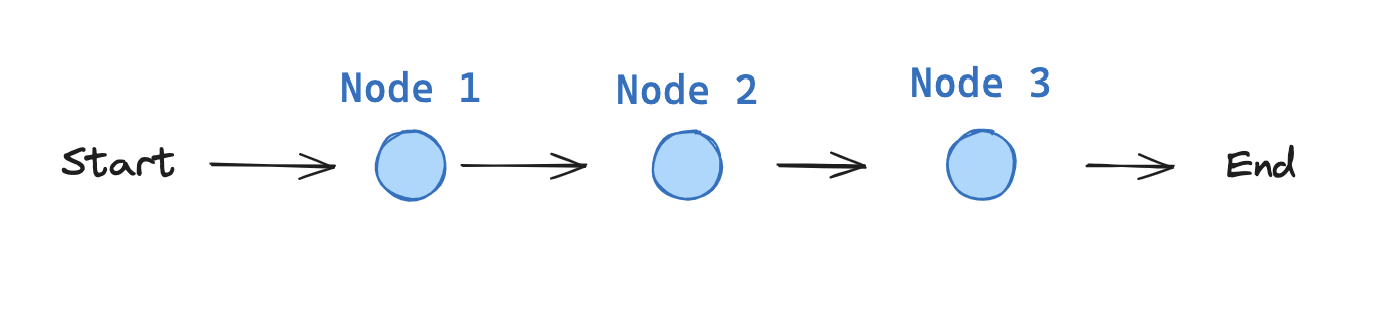

In [22]:
%%capture --no-stderr
%pip install --quiet -U langgraph

### Graph Definition

`State Definition:`
* Initialize graph (`StateGraph`) by passing a state schema 
* Here, state schema is a `TypedDict` with a single `input` field
* This represents the shared data structure for the graph

In [47]:
from typing import TypedDict

# State
class State(TypedDict):
    input: str

`Node Functions:`
* Three functions defined: `node_1`, `node_2`, `node_3`
* Each function represents a node in the graph
* Functions take state as input and print a step message

In [ ]:
from langgraph.graph import StateGraph, START, END
from IPython.display import Image, display

# Nodes
def node_1(state):
    print("---Node 1---")
    return {"input":state['input'] +" my"}


def node_2(state):
    print("---Node 2---")
    return {"input":state['input'] +" first"}


def node_3(state):
    print("---Node 3---")
    return {"input":state['input'] +" graph"}

`Graph Construction:`
* Initializes StateGraph with the State class
* Adds nodes using `add_node()` method
* Creates edges using `add_edge()` method
* Linear structure: `START -> node_1 -> node_2 -> node_3 -> END`
* Uses special `START` and `END` nodes for entry and exit points

`Graph Compilation:`
* Compiles the graph using `builder.compile()`
* Performs basic checks on graph structure
* Prepares the graph for execution

`Visualization:`
* Uses built-in visualization capabilities
* Generates and displays a Mermaid diagram of the graph structure

Reference: 

https://langchain-ai.github.io/langgraph/concepts/low_level/

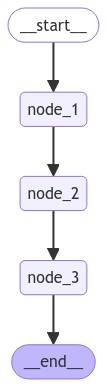

In [3]:
# Build graph
builder = StateGraph(State)
builder.add_node("node_1", node_1)
builder.add_node("node_2", node_2)
builder.add_node("node_3", node_3)
builder.add_edge(START, "node_1")
builder.add_edge("node_1", "node_2")
builder.add_edge("node_2", "node_3")
builder.add_edge("node_3", END)

# Add
graph = builder.compile()

# View
display(Image(graph.get_graph().draw_mermaid_png()))

### Graph Invocation

The compiled graph implements the [runnable](https://python.langchain.com/v0.1/docs/expression_language/interface/) protocol.

This provides a standard way to execute LangChain components. 
 
`invoke` is one of the standard methods in this interface.

`Input`
 
* The input is a dictionary `{"input":"This is"`}.
* This matches the State structure defined earlier.
* This input becomes the initial state of the graph execution.

`Execution Process:`
 
* When `invoke` is called, the graph starts execution from the `START` node.
* It progresses through the defined nodes (`node_1`, `node_2`, `node_3`) in order.
* Each node function receives the current state and can modify it.
* The execution continues until it reaches the `END` node.

`State Management:`
 
* The initial input state is passed through each node.
* Nodes can read from and write to this state.

`Synchronous Operation:`
 
* `invoke` runs the entire graph synchronously.
* This waits for each step to complete before moving to the next.

`Return Value:`
 
* The invoke method returns the final state of the graph after all nodes have executed.
* In this case, it would return the state after `node_3` has completed.

In [2]:
graph.invoke({"input":"This is"})

---Step 1---
---Step 2---
---Step 3---


{'input': 'This is my first graph'}

## Lesson 3: LangGraph Studio

We've [released an IDE called LangGraph Studio](https://blog.langchain.dev/langgraph-studio-the-first-agent-ide/), which broadly supports agentic workflows! 

You can download it [here](https://github.com/langchain-ai/langgraph-studio?tab=readme-ov-file#download) and setup a LangSmith account.

When done, simply load the `assistant` folder in this repo.

We can then select and visualize the above grade as `simplest_graph` (top right).

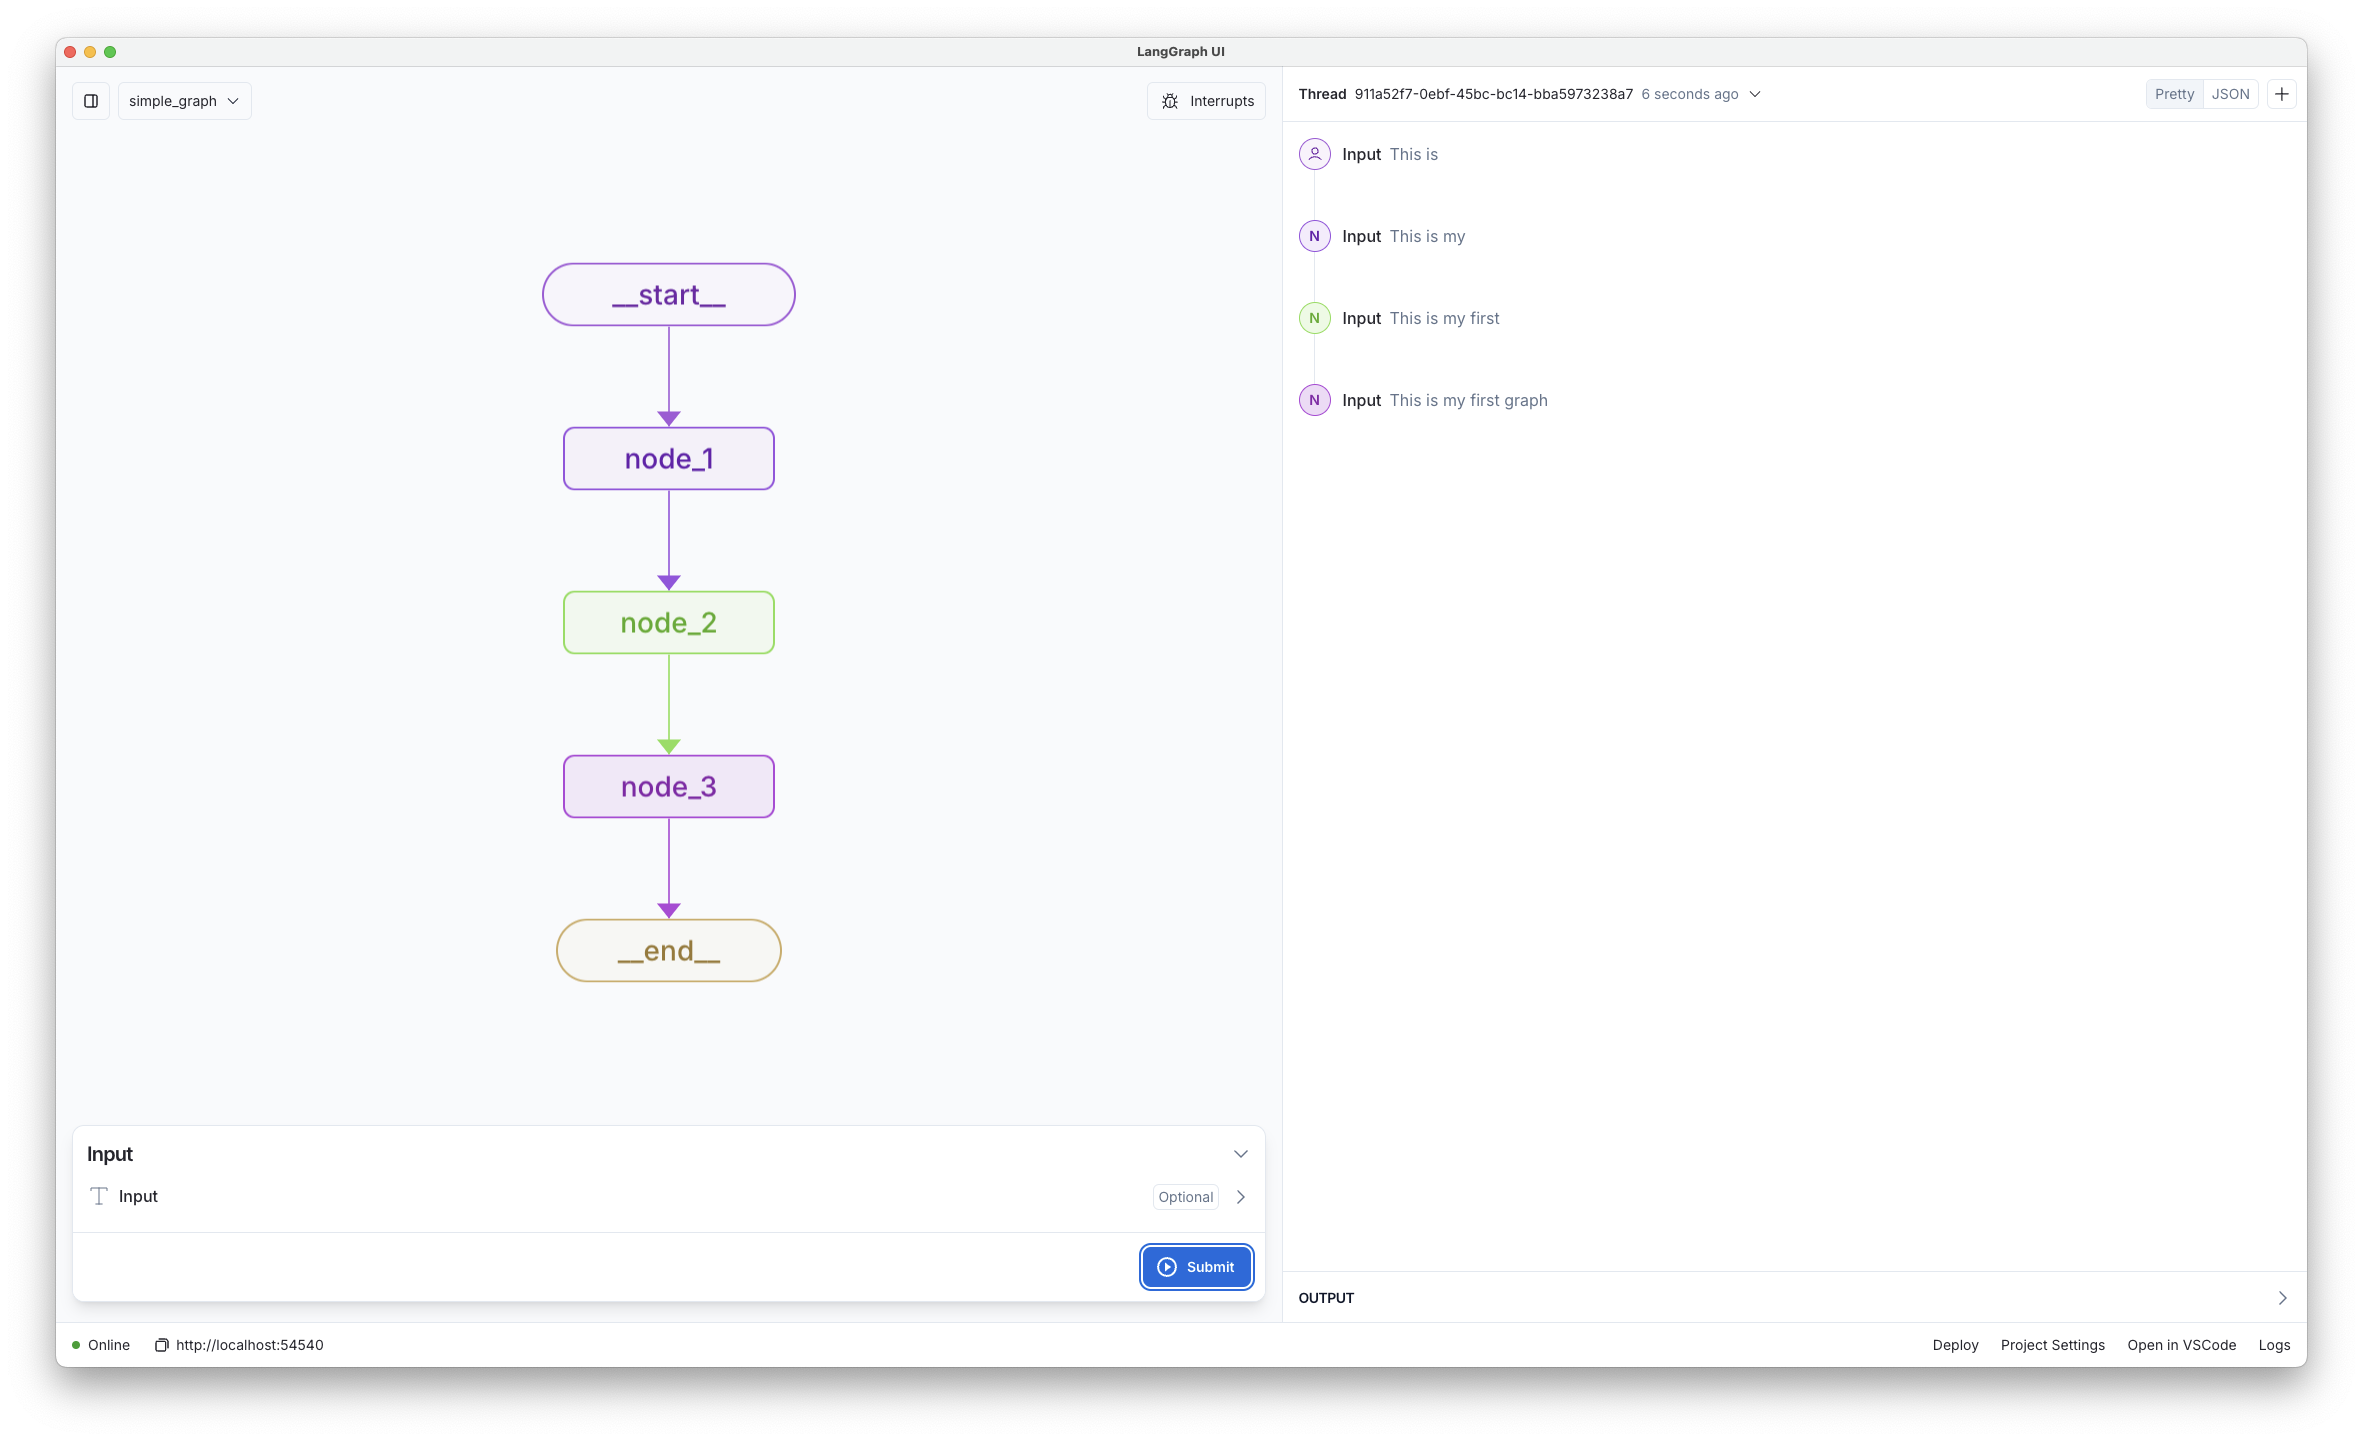

We'll be incorperating LangGraph studio into the following lessons!

## Lesson 4: LLM Chain

Now, let's build up to a simple chain that combines 4 key [concepts](https://python.langchain.com/v0.2/docs/concepts/):

1) Using [chat messages](https://python.langchain.com/v0.2/docs/concepts/#messages) in our graph
2) Using [chat models](https://python.langchain.com/v0.2/docs/concepts/#chat-models)
3) [Binding tools](https://python.langchain.com/v0.2/docs/concepts/#tools) to our LLM
4) [Executing tool calls](https://python.langchain.com/v0.2/docs/concepts/#functiontool-calling) in our graph 

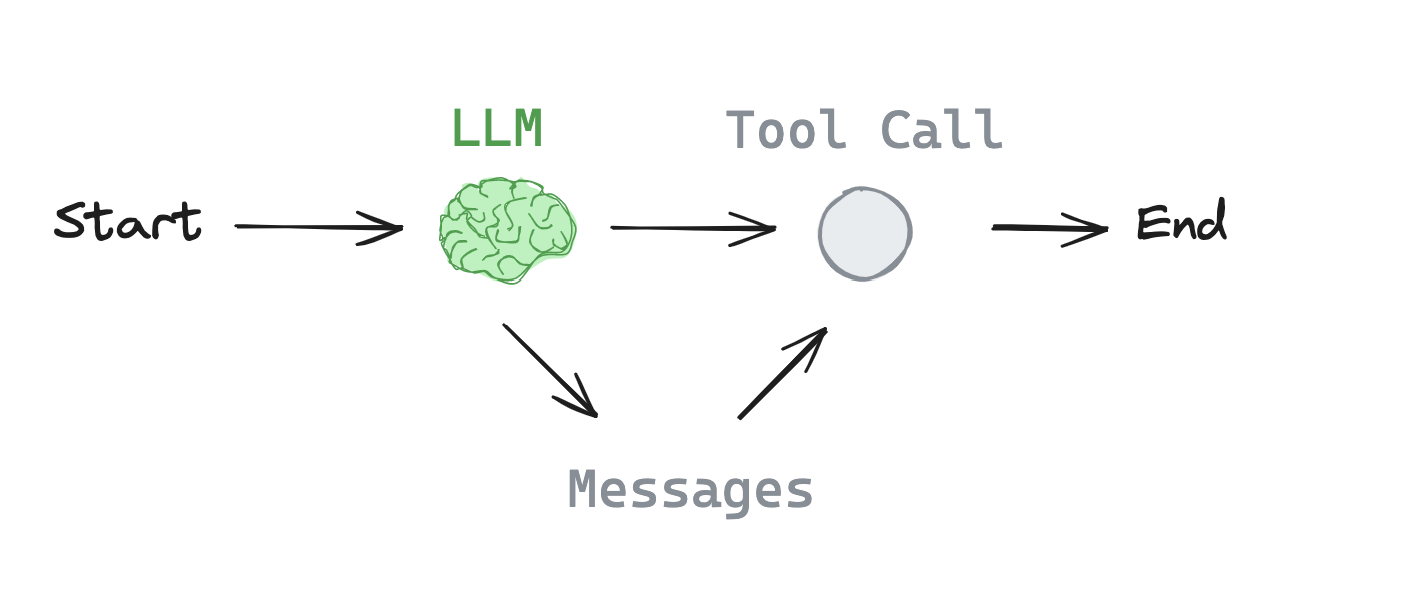

In [ ]:
%%capture --no-stderr
%pip install --quiet -U langgraph langchain_openai

### Messages

Chat models can use [`messages`](https://python.langchain.com/v0.2/docs/concepts/#messages), which capture different roles within a conversation. 

LangChain supports `HumanMessage`, `AIMessage`, `SystemMessage`, and `ToolMessage`. 

These represent a message from the user, from chat model, for the chat model to instruct behavior, and from a tool call. 

Let's create a list of messages. Each message can be supplied with a few things:

* `content` - content of the messsage
* `role` - optionally, who is creating the message
* `response_metadata` - optionally, a dict of metadata that is often specific to each model provider


In [14]:
from langchain_core.messages import AIMessage, HumanMessage
messages = [AIMessage(content=f"So you said you were researching ocean mammals?", role="Model")]
messages.extend([HumanMessage(content=f"Yes, that's right.",role="Lance")])
messages.extend([AIMessage(content=f"Great, what would you like to learn about.", role="Model")])
messages.extend([HumanMessage(content=f"I want to learn about the best place to see Orcas in the US.", role="Lance")])

In [30]:
AIMessage(content=f"So you said you were researching ocean mammals?", role="Human")

AIMessage(content='So you said you were researching ocean mammals?', role='Human')

We can view them easily using pprint, which will print the message contnet. 

In [15]:
from pprint import pprint
for m in messages:
    m.pretty_print()

================================== Ai Message ==================================

So you said you were researching ocean mammals?
================================ Human Message =================================

Yes, that's right.
================================== Ai Message ==================================

Great, what would you like to learn about.
================================ Human Message =================================

I want to learn about the best place to see Orcas in the US.


In [16]:
m.content, m.role

('I want to learn about the best place to see Orcas in the US.', 'Lance')

### Chat Models

[Chat models](https://python.langchain.com/v0.2/docs/concepts/#chat-models) can use a sequence of message as input and support message roles, as discussed above.

Here, ensure your `OPENAI_API_KEY` is set:

In [ ]:
import os, getpass

def _set_env(var: str):
    if not os.environ.get(var):
        os.environ[var] = getpass.getpass(f"{var}: ")

_set_env("OPENAI_API_KEY")

We can load a chat model and invoke it with out list of messages.

In [17]:
from langchain_openai import ChatOpenAI
llm = ChatOpenAI(model="gpt-4o")
result = llm.invoke(messages)

We can see that the result is an `AIMessage`.

In [20]:
type(result)

langchain_core.messages.ai.AIMessage

We can see the `content` of the message.

In [22]:
result.pretty_print()

================================== Ai Message ==================================

One of the best places to see orcas in the United States is the San Juan Islands in Washington State. Here are a few details about this prime location:

### San Juan Islands, Washington
1. **Location**: The San Juan Islands are located in the northwest corner of Washington State, in the Salish Sea.
2. **Accessibility**: The islands can be accessed by ferry, small plane, or private boat from mainland Washington.
3. **Best Time to Visit**: The peak season for seeing orcas is from May through September. During this time, orcas are often seen as they hunt for salmon.
4. **Types of Orcas**: The region is home to both resident and transient orcas. The resident orcas are more commonly seen and are particularly known for their fish-eating habits, while transient orcas are mammal-eaters.
5. **Tour Operators**: Several tour companies operate whale-watching excursions, providing opportunities to see orcas and other 

No specific `role` is assigned by the chat model.

But we do have `response_metadata` from the model provider.

In [27]:
result.response_metadata

{'token_usage': {'completion_tokens': 399,
  'prompt_tokens': 59,
  'total_tokens': 458},
 'model_name': 'gpt-4o-2024-05-13',
 'system_fingerprint': 'fp_3aa7262c27',
 'finish_reason': 'stop',
 'logprobs': None}

### Binding tools

Tools are needed whenever you want a model to control parts of your code or call out to external APIs.

[Many LLM providers support tool calling](https://python.langchain.com/v0.1/docs/integrations/chat/).

The [tool calling interface](https://blog.langchain.dev/improving-core-tool-interfaces-and-docs-in-langchain/) in LangChain is simple. 

You can pass any Python function into `ChatModel.bind_tools()`.

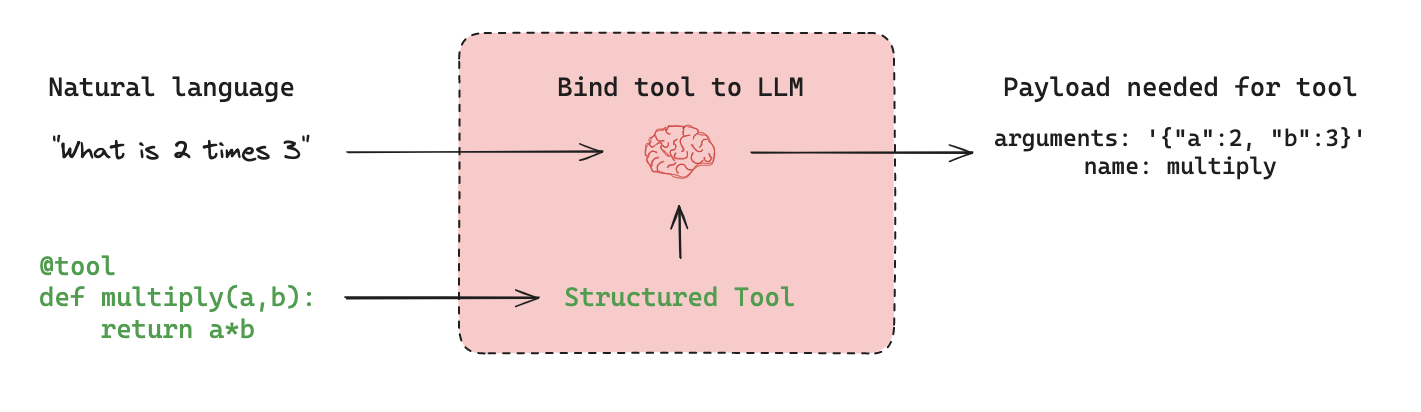

In [4]:
# This will be a tool
def multiply(a: int, b: int) -> int:
    """Multiply a and b.

    Args:
        a: first int
        b: second int
    """
    return a * b

# LLM with bound tool
llm_with_tools = llm.bind_tools([multiply])

### Using messages and chat models in our graph

#### Type

With these foundations in place, we can now dicuss how to use [`messages`](https://python.langchain.com/v0.2/docs/concepts/#messages) in our graph state.

Let's define our state `MessagesState`. 

It's defined as a `TypedDict` with a single key: `messages`.

`messages` is simply a list of type `AnyMessage`, meaning it's a list of messages.

Now, we have a minor problem: as our graph runs, we want to append messages to to our `messages` state key.

In order to do this, we need to introduce the concept of reducers.

#### Reducer

[Reducer functions](https://langchain-ai.github.io/langgraph/concepts/low_level/#reducers) allow us to specify how state updates are perfomred.

If no reducer function is explicitly specified, then it is assumed that all updates to that key should *override it*.

Since we want to append messages, we can speciify a reducer: we'll use the pre-built `add_messages` reducer!

This ensures that state updates you send to the graph are appended to the existing list of messages.

We use`Annotated` to associate our reducer function as metadata to our key.

In [31]:
from typing import Annotated
from langchain_core.messages import AnyMessage
from langgraph.graph.message import add_messages

class MessagesState(TypedDict):
    messages: Annotated[list[AnyMessage], add_messages]

Since having a list of messages in your state is so common, LangGraph has a pre-built [`MessagesState`](https://langchain-ai.github.io/langgraph/concepts/low_level/#messagesstate)! 

`MessagesState` is defined: 

* With a pre-build single `messages` key
* Which is a list of `AnyMessage` objects and uses the `add_messages` reducer

In [33]:
from langgraph.graph import MessagesState

class State(MessagesState):
    # Add any keys needed beyond messages, which is pre-built 
    pass

The `MessagesState` and `State` both work equivalently!

In [40]:
# Initial state
initial_messages = messages=[
    AIMessage(content="Hello! How can I assist you?", role="Model"),
    HumanMessage(content="I'm looking for information on marine biology.", role="User"),
]

# New message to add
new_message_1 = AIMessage(content="Sure, I can help with that. What specifically are you interested in?", role="Model")

# Try with MessagesState
initial_state = MessagesState(messages=initial_messages)
updated_state = MessagesState(messages=add_messages(initial_state['messages'], [new_message_1]))
print(updated_state)

{'messages': [AIMessage(content='Hello! How can I assist you?', id='e753d67f-6e6e-4783-8912-200e5dfd149a', role='Model'), HumanMessage(content="I'm looking for information on marine biology.", id='4388f54c-e454-487f-a4a9-0a2703c7b63b', role='User'), AIMessage(content='Sure, I can help with that. What specifically are you interested in?', id='07555e21-824f-43cf-90b0-8bf3786265ea', role='Model')]}


In [39]:
# Try with State
initial_state = State(messages=initial_messages)
updated_state = MessagesState(messages=add_messages(initial_state['messages'], [new_message_1]))
print(updated_state)

{'messages': [AIMessage(content='Hello! How can I assist you?', id='668761d9-f2e9-4e53-85a2-514e4fe4eb06', role='Model'), HumanMessage(content="I'm looking for information on marine biology.", id='28dc6b79-5a95-4c44-8311-6f2409d6f5d5', role='User'), AIMessage(content='Sure, I can help with that. What specifically are you interested in?', id='759763a8-c3c8-46e5-837f-9a794c9469b3', role='Model')]}


#### Using this with our graph

Now, let use `MessagesState` with a graph.

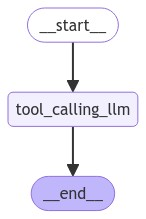

In [41]:
# State
class MessagesState(MessagesState):
    # Add any keys needed beyond messages, which is pre-built 
    pass
    
# Node
def tool_calling_llm(state: MessagesState):
    return {"messages": [llm_with_tools.invoke(state["messages"])]}

# Build grapph
builder = StateGraph(MessagesState)
builder.add_node("tool_calling_llm", tool_calling_llm)
builder.add_edge(START, "tool_calling_llm")
builder.add_edge("tool_calling_llm", END)
graph = builder.compile()

# View
display(Image(graph.get_graph().draw_mermaid_png()))

Here, the LLM responds normally without any tool calls.

In [7]:
messages = graph.invoke({"messages": ("user", "Hello!")})
messages['messages'][-1]

AIMessage(content='Hi there! How can I help you today?', response_metadata={'token_usage': {'completion_tokens': 11, 'prompt_tokens': 54, 'total_tokens': 65}, 'model_name': 'gpt-4o-2024-05-13', 'system_fingerprint': 'fp_3aa7262c27', 'finish_reason': 'stop', 'logprobs': None}, id='run-0bef67f6-9137-4f65-896a-f2022372f9ed-0', usage_metadata={'input_tokens': 54, 'output_tokens': 11, 'total_tokens': 65})

Now, we can see that a tool call is performed if our input related to the tool!

In [6]:
messages = graph.invoke({"messages": ("user", "Multiply 3 and 2")})
messages['messages'][-1].tool_calls

[{'name': 'multiply',
  'args': {'a': 3, 'b': 2},
  'id': 'call_XCxS5HjnirZqAMZFgrynUkiv',
  'type': 'tool_call'}]

#### Conditional edge

Now, we can see that our chat model either:

* Returns a tool call
* Returns a natural langage response

We can easily have our graph work with either output! 

For this, we can use two ideas:

(1) A node that will call our tool 

(2) A conditional edge that will route to our tool calling node or simply end if no tool call is performed 

For (1) we use the [built-in `ToolNode`](https://langchain-ai.github.io/langgraph/reference/prebuilt/?h=tools+condition#toolnode) and simply pass a list of our tools.

For (2) we use the [built-in `tools_condition`](https://langchain-ai.github.io/langgraph/reference/prebuilt/?h=tools+condition#tools_condition).

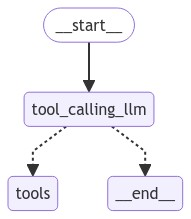

In [43]:
from langgraph.prebuilt import ToolNode
from langgraph.prebuilt import tools_condition

# Build graph
builder = StateGraph(MessagesState)
builder.add_node("tool_calling_llm", tool_calling_llm)
builder.add_node("tools", ToolNode([multiply]))
builder.add_edge(START, "tool_calling_llm")
builder.add_conditional_edges(
    "tool_calling_llm",
    # If the latest message (result) from assistant is a tool call -> tools_condition routes to tools
    # If the latest message (result) from assistant is a not a tool call -> tools_condition routes to END
    tools_condition,
)
graph = builder.compile()

# View
display(Image(graph.get_graph().draw_mermaid_png()))

In [46]:
messages = graph.invoke({"messages": ("user", "Multiply 3 and 2")})
for m in messages['messages']:
    m.pretty_print()

================================ Human Message =================================

Multiply 3 and 2
================================== Ai Message ==================================
Tool Calls:
  multiply (call_yrloa04llVmqHaW51A6skOpv)
 Call ID: call_yrloa04llVmqHaW51A6skOpv
  Args:
    a: 3
    b: 2
================================= Tool Message =================================
Name: multiply

6


Now, we can see that the graph runs the tool!

It responds with a `ToolMessage`. 

In [8]:
messages = graph.invoke({"messages": ("user", "Multiply 3 and 2")})
messages['messages'][-1]

ToolMessage(content='6', name='multiply', id='a1747017-2083-42ea-a3ed-e66539ddb1b2', tool_call_id='call_fiQpCK6A87dbygZTZo4EEtAA')

Here, we can also introduce [LangGraph Studio](https://github.com/langchain-ai/langgraph-studio?tab=readme-ov-file).

This is free to anyone with a LangSmith account.

It offers an agent IDE that enables visualization, interaction, and debugging of complex agentic applications. 

Follow the `README` [here](https://github.com/langchain-ai/langgraph-studio?tab=readme-ov-file) to set up LangGraph Studio.

Load the above graph with `chain.py`. 

We can interact with our loaded graph, as shown above. 

We'll explore more advanced usage of studio in future lessons and modules!

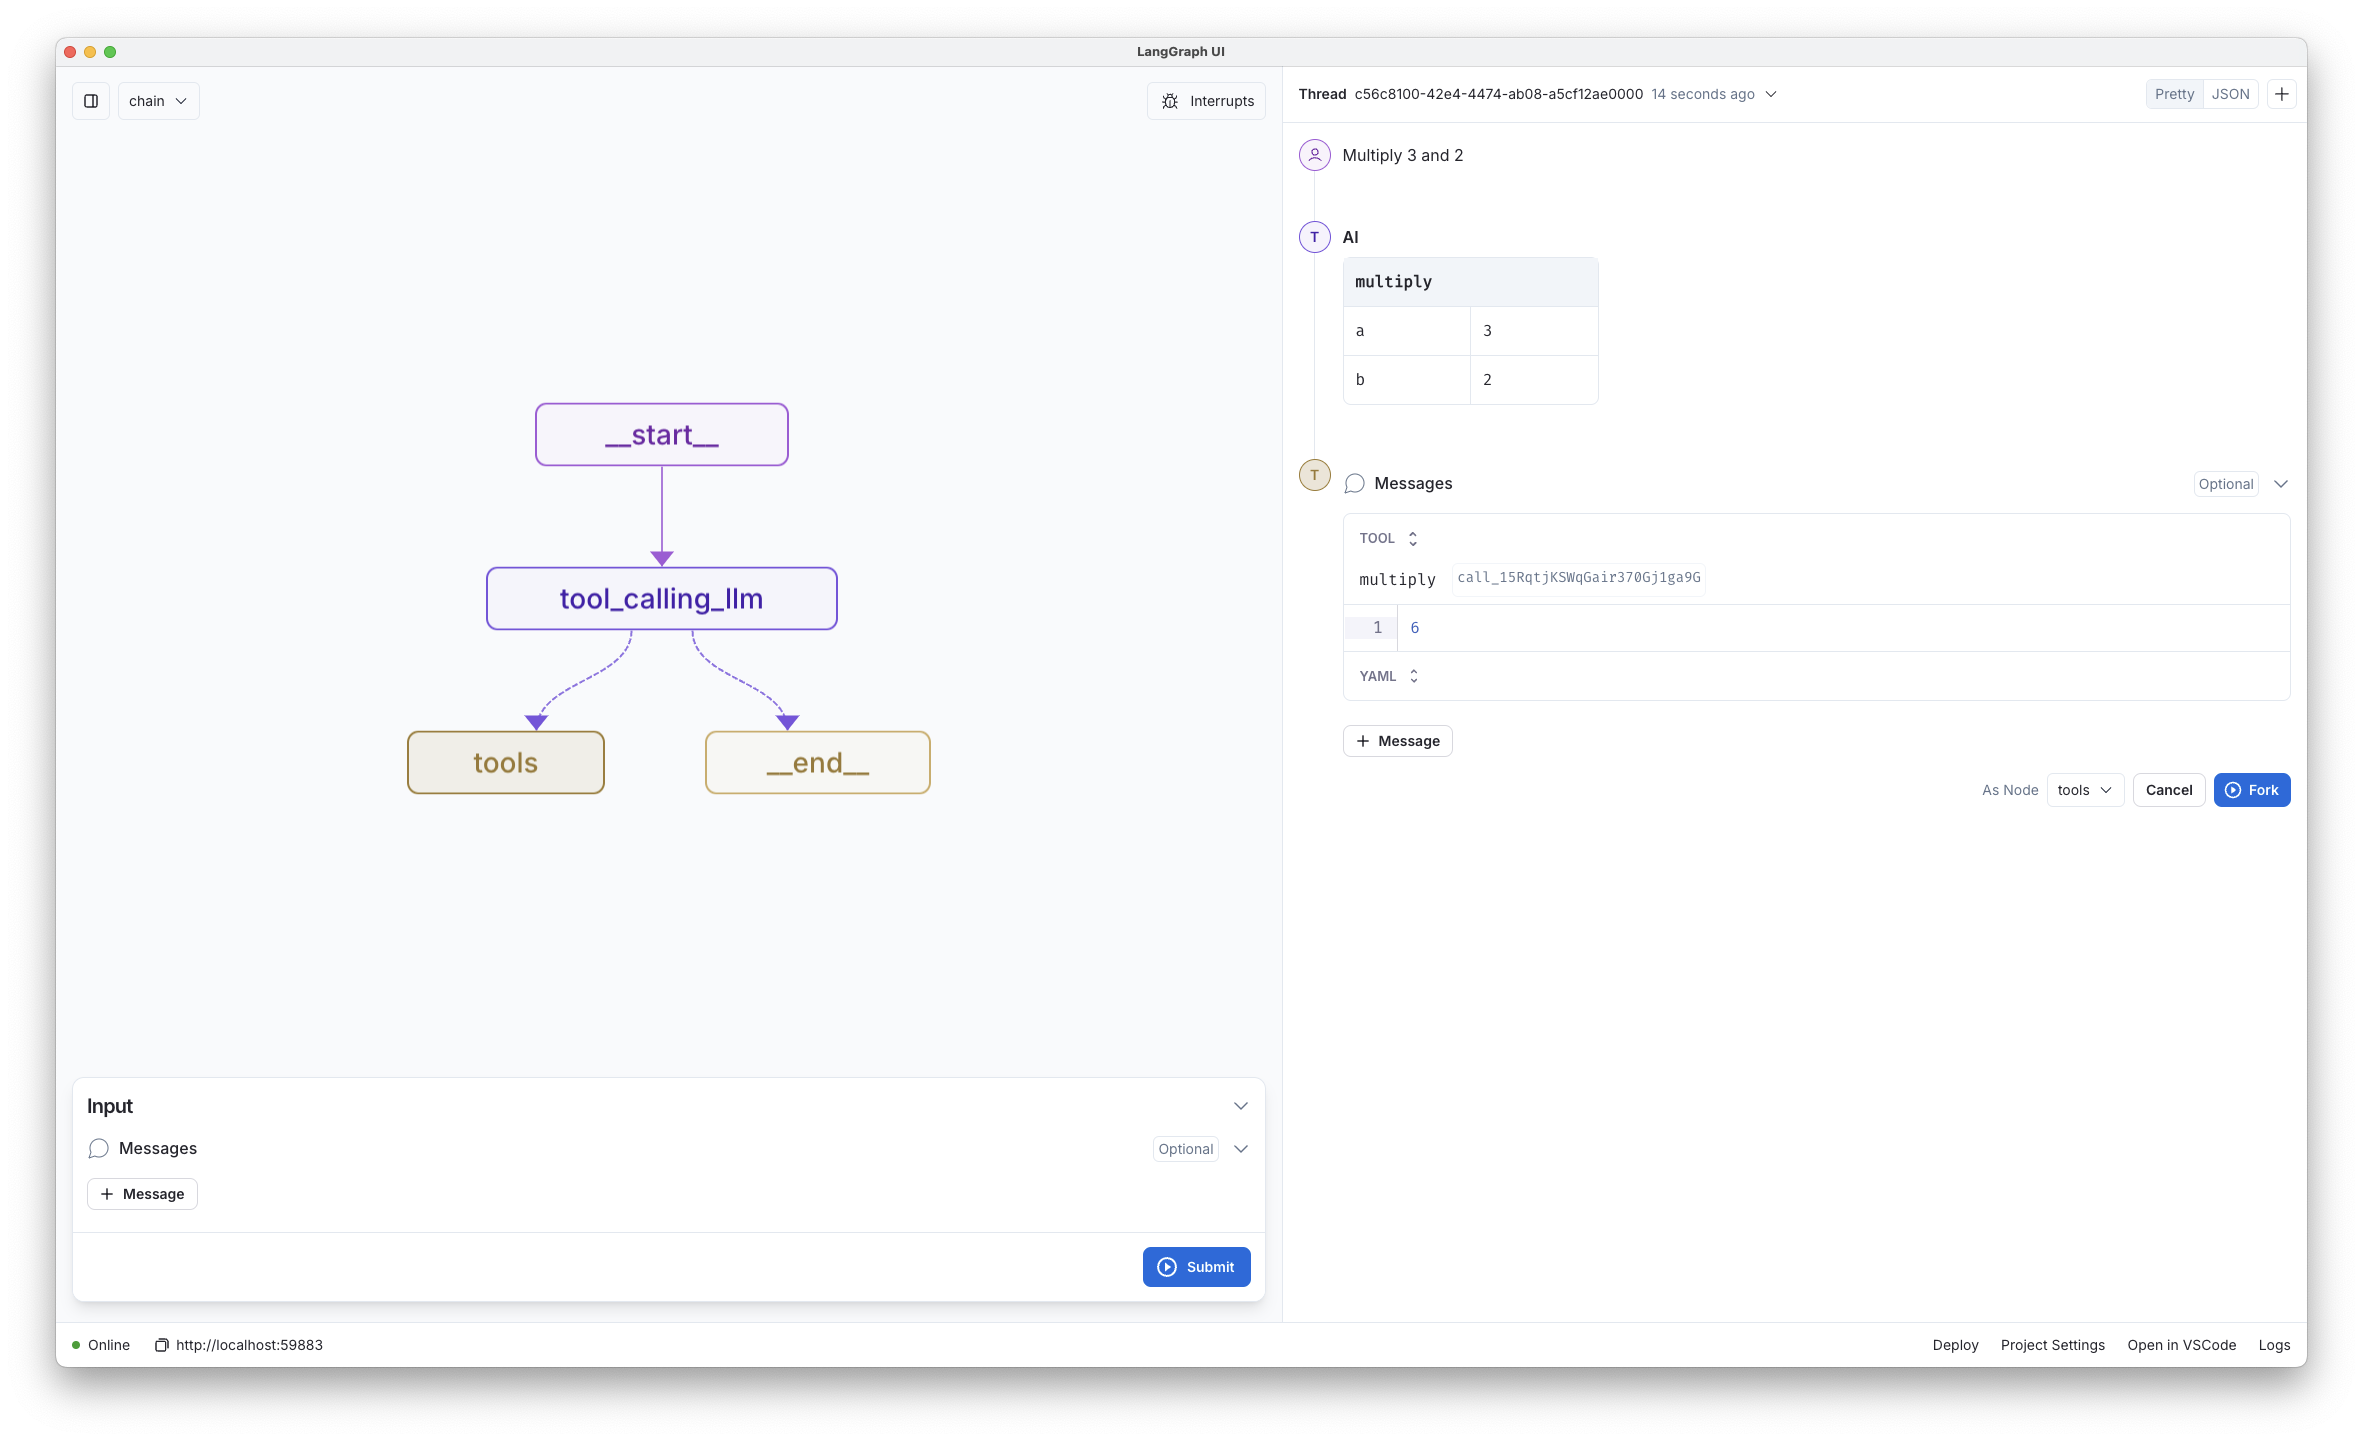

## Lesson 5: ReAct

With the above concepts clear, we can combine these into a [tool calling agent](https://python.langchain.com/v0.1/docs/modules/agents/agent_types/tool_calling/)! 

The idea is simple: 

Above, we invoked our LLM, it chose to call a tool, and the tool executed, resuting a `ToolMessage`.

Above, we just returned the raw `ToolMessage` to the user.
 
But, what if we simply pass that `ToolMessage` back to the LLM and let it either:

* Call another tool
* Or, just respond directly based upon the tool's output

This is the basic intution behind [ReAct](https://react-lm.github.io/), a simple, general, and flexible framework for building agents.
  
(1) `act` - call specific tools 
 
(2) `observe` - pass the tool outputs back to the LLM
 
(3) `reason` - about the tool output to decide what to do next 

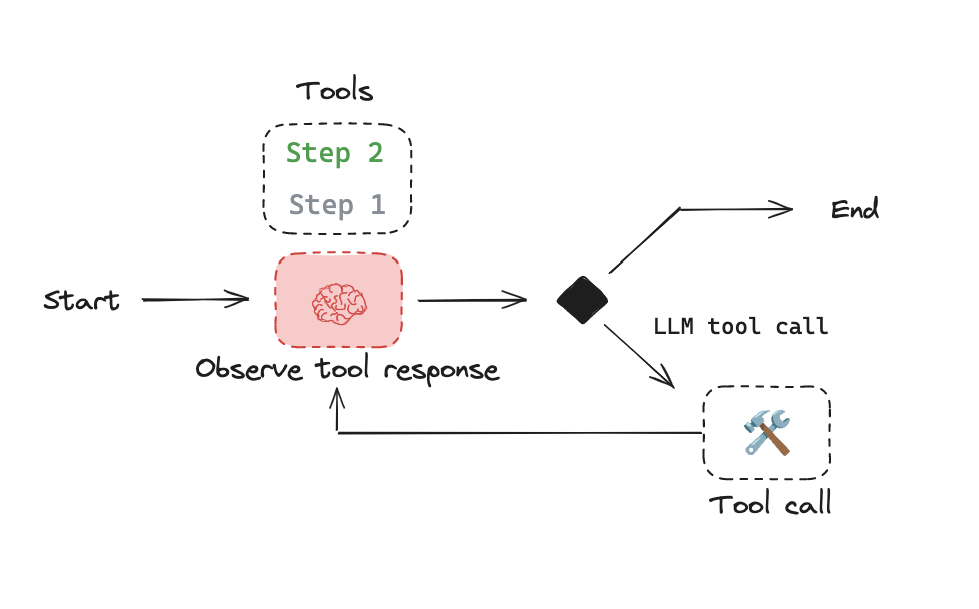

This [general purpose cognitive architecture](https://blog.langchain.dev/planning-for-agents/) can applied to any set of tools. 
 
Let's create a few new tools, `add` and `divide`.

In [49]:
# This will be a tool
def add(a: int, b: int) -> int:
    """Adds a and b.

    Args:
        a: first int
        b: second int
    """
    return a + b

def divide(a: int, b: int) -> float:
    """Adds a and b.

    Args:
        a: first int
        b: second int
    """
    return a / b

tools = [add, multiply, divide]

Let's create our LLM and prompt it with the overall desired agent behavior.

Here, we're going to use [prompt templates](https://python.langchain.com/v0.2/docs/concepts/#prompt-templates):

* Prompt templates help to translate user input and parameters into instructions for a language model
* In particular, [it gives us a nice way](https://python.langchain.com/v0.2/docs/concepts/#messagesplaceholder) to add messages in with some general instructions via `("placeholder", "{messages}")`!

We'll also use [chaining](https://python.langchain.com/v0.2/docs/tutorials/llm_chain/#chaining-together-components-with-lcel) with the pipe (`|`) operator connect a promopt template with our LLM.

In [50]:
from typing import Annotated, List
from typing_extensions import TypedDict
from langchain_core.prompts import ChatPromptTemplate
from langgraph.graph.message import AnyMessage, add_messages

# State
class MessagesState(TypedDict):
    messages: Annotated[list[AnyMessage], add_messages]

# Assistant
class Assistant:
    def __init__(self, llm):
        """
        Initialize the Assistant with llm.
        """
        self.llm = llm

    def __call__(self, state: MessagesState, config):
        """
        Call method to invoke
        """
        result = self.llm.invoke(state)  
        return {"messages": result}

# Assistant prompt
primary_assistant_prompt = ChatPromptTemplate.from_messages(
    [
        (
            "system",
            " You are a helpful assistant tasked with writing performing arithmatic on a set of inputs. "
         ),
        ("placeholder", "{messages}"),
    ]
)

# Prompt our LLM and bind tools
assistant = primary_assistant_prompt | llm.bind_tools(tools)

`State Management:`

* Uses `MessagesState`, a TypedDict with a single key 'messages'.
* The 'messages' key is annotated with `add_messages`, a reducer function that appends new messages to the existing list.

`Tools:`
* Defines a list of tools.
* These tools are bound to the LLM.

`Assistant:`
* Implements an `Assistant` class that wraps a runnable object (the LLM with bound tools).
* The assistant processes the current state and returns updated messages.

`Graph Structure:`
* Creates a `StateGraph` with two main nodes: "assistant" and "tools".
* The "assistant" node runs the LLM with the current state.
* The "tools" node executes the appropriate tool based on the LLM's output.

`Conditional Edge:`
* Uses `add_conditional_edges` with the `tools_condition` function.
* This is crucial for the ReAct architecture:
* After the "assistant" node executes, `tools_condition` checks if the LLM's output is a tool call.
* If it is a tool call, the flow is directed to the "tools" node.
* If it's not a tool call, the flow is directed to END, terminating the process.

Overall, the loop will continue so long as the LLM decides to call specific tools.

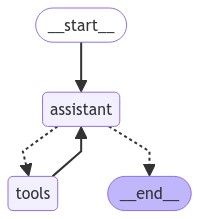

In [51]:
from langgraph.graph import START, END, StateGraph
from langgraph.prebuilt import tools_condition
from IPython.display import Image, display

# Graph
builder = StateGraph(MessagesState)

# Define nodes: these do the work
builder.add_node("assistant", Assistant(assistant))
builder.add_node("tools", ToolNode(tools))

# Define edges: these determine how the control flow moves
builder.add_edge(START, "assistant")
builder.add_conditional_edges(
    "assistant",
    # If the latest message (result) from assistant is a tool call -> tools_condition routes to tools
    # If the latest message (result) from assistant is a not a tool call -> tools_condition routes to END
    tools_condition,
)
builder.add_edge("tools", "assistant")
react_graph = builder.compile()

# Show
display(Image(react_graph.get_graph(xray=True).draw_mermaid_png()))

`Flow:`
* Starts at the "assistant" node.
* The assistant generates a response or a tool call.
* If it's a tool call, the flow goes to the "tools" node, which executes the tool.
* After tool execution, it loops back to the "assistant" node.
* This cycle continues until the assistant doesn't make a tool call, at which point it ends.
 
The conditional edge is key to implementing the ReAct architecture. It allows the agent to:
1. Reason about whether to use a tool (in the "assistant" node).
2. Act by calling the tool if needed (routing to the "tools" node).
3. Observe the results (by looping back to the "assistant" node with updated state).
4. Decide when to stop (by not making a tool call, which routes to END).

In [13]:
messages = react_graph.invoke({"messages": ("user", "Add 3 and 4, then multiple by 2, and finally divide by 5")})
messages['messages'][-1]

AIMessage(content='The result of adding 3 and 4, then multiplying by 2, and finally dividing by 5 is 2.8.', response_metadata={'token_usage': {'completion_tokens': 29, 'prompt_tokens': 227, 'total_tokens': 256}, 'model_name': 'gpt-4o-2024-05-13', 'system_fingerprint': 'fp_3aa7262c27', 'finish_reason': 'stop', 'logprobs': None}, id='run-0e542352-dfda-4050-825e-820f0cf9623a-0', usage_metadata={'input_tokens': 227, 'output_tokens': 29, 'total_tokens': 256})

As shown above, we can develop and interact with our agent in Studio.

Simply load `agent.py`. 

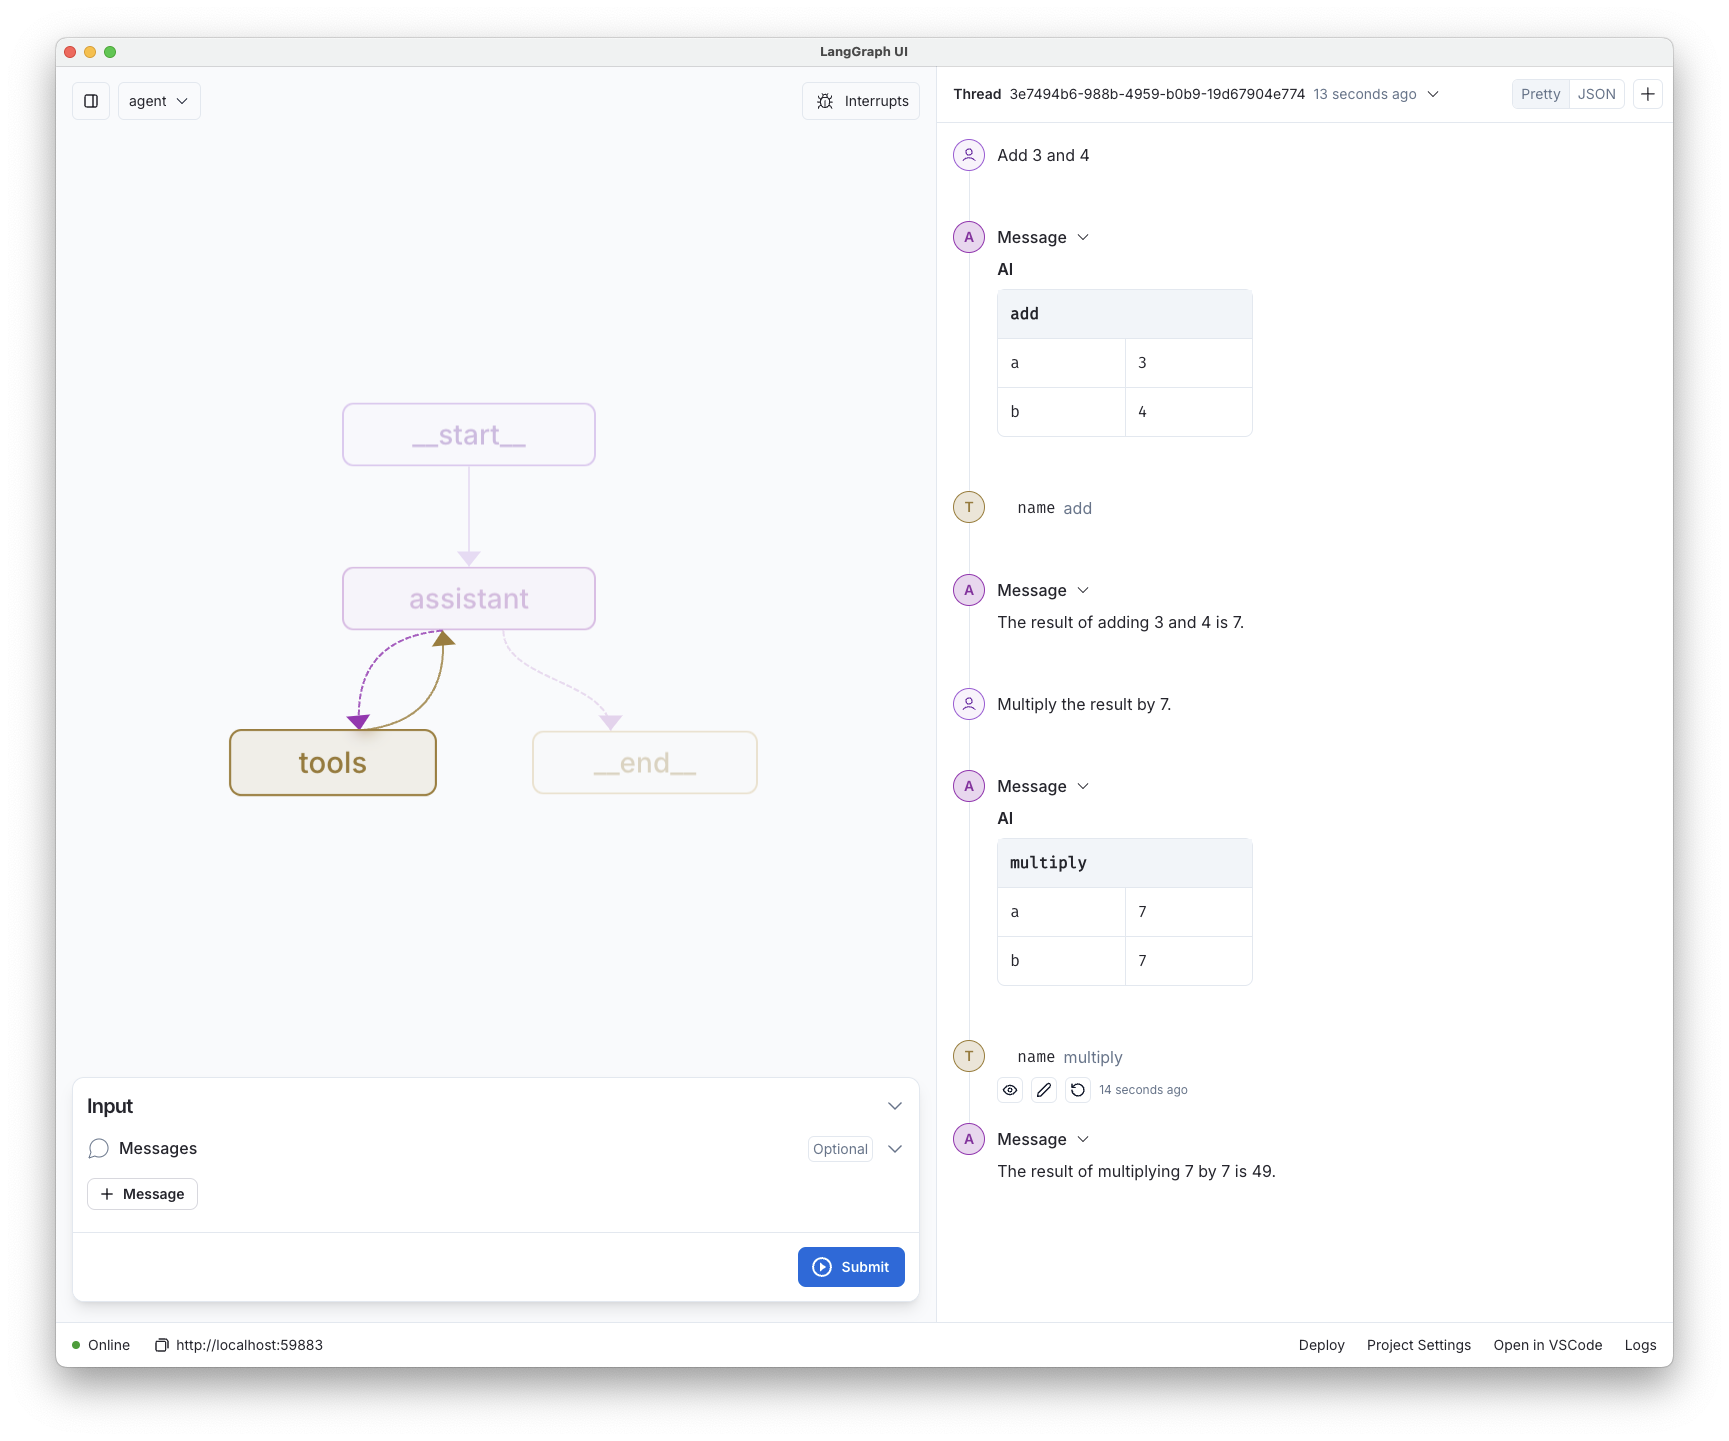

### Lesson 6: ReAct with Memory

Our chatbot can now use tools to answer user questions, but it doesn't remember the context of previous interactions. 

This limits its ability to have coherent, multi-turn conversations.

We can use [memory](https://langchain-ai.github.io/langgraph/how-tos/persistence/) to address this! 

LangGraph has support for various types of memory.

One of the easiest to work with is simply `MemorySaver`, an in-memory key-value store for your graph state.

This allows the graph to save its state after each step.

In [14]:
from langgraph.checkpoint.memory import MemorySaver
memory = MemorySaver()

# Compile with memory
react_graph_memory = builder.compile(checkpointer=memory)

`configurable` sets up a configuration with a thread ID.

This thread ID will maintain a specific conversation state.

When we stream, by default we will return a `key`-`value` pair of `node`-`state`.

We can simply only stream the state by passing `stream_mode="values"`.

In [15]:
config = {"configurable": {"thread_id": "1"}}

user_input = "Hi there! Add 3 and 4"
events = react_graph_memory.stream(
    {"messages": [("user", user_input)]}, config, stream_mode="values"
)
for event in events:
    event["messages"][-1].pretty_print()

================================ Human Message =================================

Hi there! Add 3 and 4
================================== Ai Message ==================================
Tool Calls:
  add (call_hqsxtZ9nOXxnHaBWcmaaLQMH)
 Call ID: call_hqsxtZ9nOXxnHaBWcmaaLQMH
  Args:
    a: 3
    b: 4
================================= Tool Message =================================
Name: add

7
================================== Ai Message ==================================

The sum of 3 and 4 is 7.


In [16]:
event

{'messages': [HumanMessage(content='Hi there! Add 3 and 4', id='9d05245c-804a-4f68-8c41-ac584e5ea4be'),
  AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_hqsxtZ9nOXxnHaBWcmaaLQMH', 'function': {'arguments': '{"a":3,"b":4}', 'name': 'add'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 17, 'prompt_tokens': 140, 'total_tokens': 157}, 'model_name': 'gpt-4o-2024-05-13', 'system_fingerprint': 'fp_3aa7262c27', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run-89b588e8-07b5-448d-9eb9-1ebcbe98ad38-0', tool_calls=[{'name': 'add', 'args': {'a': 3, 'b': 4}, 'id': 'call_hqsxtZ9nOXxnHaBWcmaaLQMH', 'type': 'tool_call'}], usage_metadata={'input_tokens': 140, 'output_tokens': 17, 'total_tokens': 157}),
  ToolMessage(content='7', name='add', id='86182fb9-65b6-4a73-9a89-43e4c4f4ae81', tool_call_id='call_hqsxtZ9nOXxnHaBWcmaaLQMH'),
  AIMessage(content='The sum of 3 and 4 is 7.', response_metadata={'token_usage': {'completion_tokens': 13, 'prom

The `Configuration Setup` with thread ID allows us to proceed from the previously logged state.

In [17]:
user_input = "Take that output, and multiply it by 3!"

# The config is the **second positional argument** to stream() or invoke()!
events = react_graph_memory.stream(
    {"messages": [("user", user_input)]}, config, stream_mode="values"
)
for event in events:
    event["messages"][-1].pretty_print()

================================ Human Message =================================

Take that output, and multiply it by 3!
================================== Ai Message ==================================
Tool Calls:
  multiply (call_IOOpbLvYzfyE7RWctwvbK00f)
 Call ID: call_IOOpbLvYzfyE7RWctwvbK00f
  Args:
    a: 7
    b: 3
================================= Tool Message =================================
Name: multiply

21
================================== Ai Message ==================================

The result of multiplying 7 by 3 is 21.


In [18]:
snapshot = react_graph_memory.get_state(config)

`Overall:`

- The use of a checkpointer allows the graph to maintain state between interactions.
- The thread ID in the config ensures that multiple conversations can be managed separately.
- By using the same thread ID in both interactions, the graph maintains context, allowing for coherent multi-turn conversations.
- The `stream()` method is used instead of `invoke()`, allowing for real-time processing and display of responses.
- The state snapshots (`get_state()`) provide a way to inspect the internal state of the conversation at different points.

When you work with the agent in Studio, [it will automatically create a new thread](https://github.com/langchain-ai/langgraph-studio?tab=readme-ov-file#create-a-thread).

### Lesson 7: Deployment

So, we can recap! 

We've built 3 different cognitive architectures in LangGraph, and shown each in Studio:

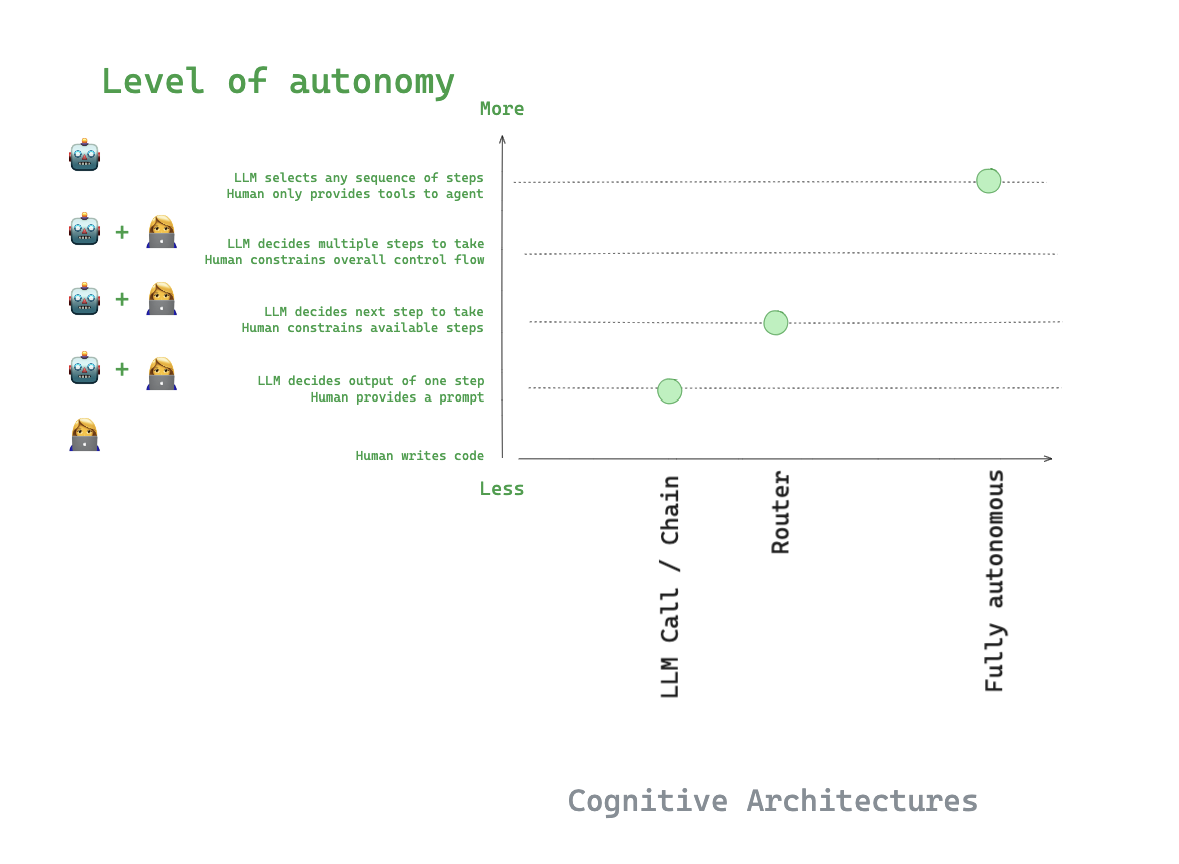

What if we wanted to deploy any of these.

We can use [LangGraph Cloud](https://langchain-ai.github.io/langgraph/cloud/) for this.

In the `assistants` directory, [we can follow these instructions](https://langchain-ai.github.io/langgraph/cloud/quick_start/#test-the-graph-build-locally):

1) Confirm LangGraph API server runs locally: 
```
langgraph up
```

2) Then, [follow instructions](https://langchain-ai.github.io/langgraph/cloud/quick_start/#deploy-from-github-with-langgraph-cloud) to set up a deployment using GitHub.